<a href="https://colab.research.google.com/github/varad0207/Keras-NLP/blob/main/data_preprocessong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import string
from collections import defaultdict
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Data Preprocessing & EDA

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
print(f'Training data shape: {train_df.shape}')
print(f'Test data shape: {test_df.shape}')
print(f'\nPercentage of missing values in training data: \n{(train_df.isna().sum()/len(train_df))*100}')
print(f'Percentage of missing values in test data: \n{(test_df.isna().sum()/len(test_df))*100}')

Training data shape: (7613, 5)
Test data shape: (3263, 4)

Percentage of missing values in training data: 
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64
Percentage of missing values in test data: 
id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64


We can see there are null values for 'keyword' and 'location'. Replace these null values with 'no_keyword' and 'no_location' respectively

In [ ]:
for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
print(f'Number of unique values for Keyword: \nTraining data - {train_df["keyword"].nunique()} \nTesting data - {test_df["keyword"].nunique()}')
print(f'\nNumber of unique values for Location: \nTraining data - {train_df["location"].nunique()} \nTesting data - {test_df["location"].nunique()}')

Number of unique values for Keyword: 
Training data - 222 
Testing data - 222

Number of unique values for Location: 
Training data - 3342 
Testing data - 1603


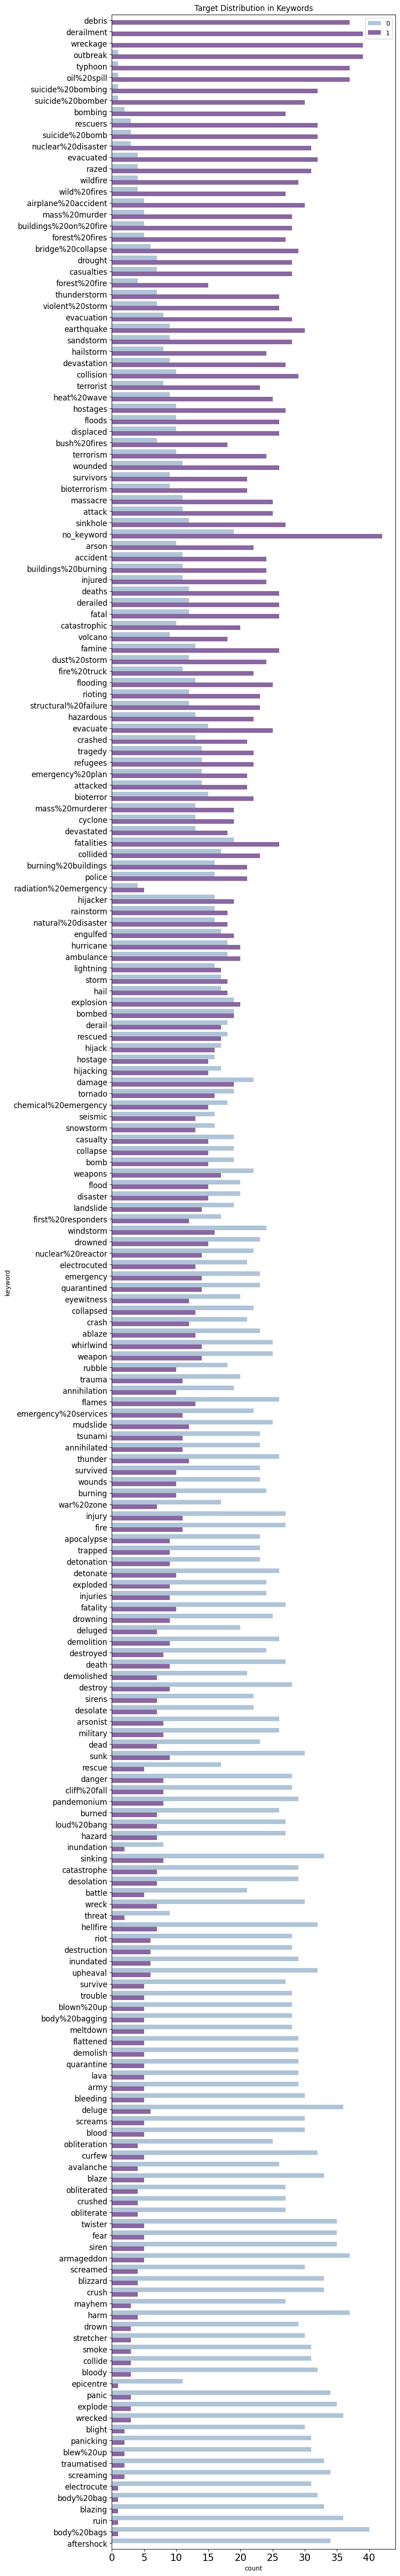

In [ ]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'], hue=train_df.sort_values(by='target_mean', ascending=False)['target'], palette='BuPu')

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_df.drop(columns=['target_mean'], inplace=True)

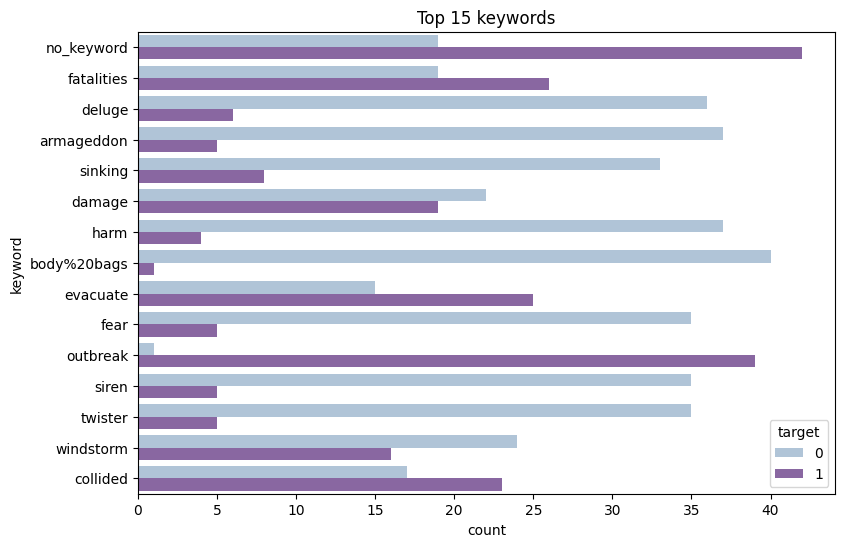

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_df['keyword'], order = train_df['keyword'].value_counts().iloc[:15].index, hue=train_df['target'], palette='BuPu')
plt.title('Top 15 keywords')
plt.show()

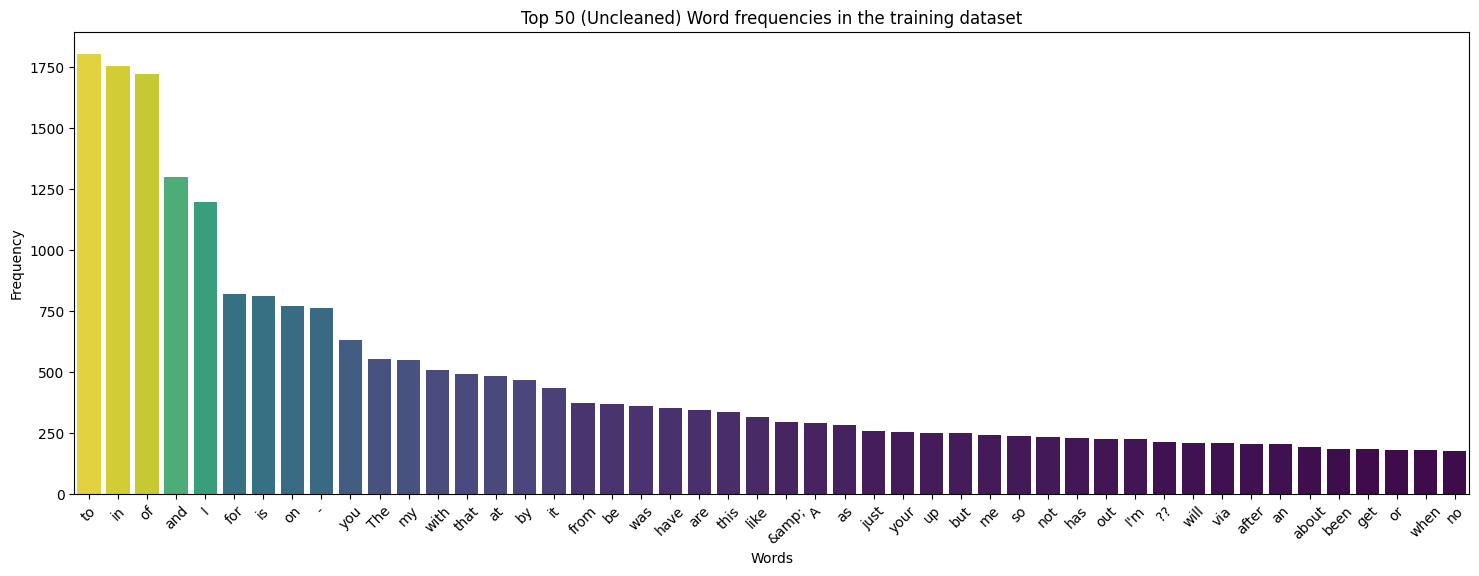

In [ ]:
all_words = train_df['text'].str.split(expand=True).unstack().value_counts()

plt.figure(figsize=(18, 6), dpi=100)
sns.barplot(x=all_words.index.values[2:50], y=all_words.values[2:50], hue=all_words.values[2:50], palette='viridis', legend=False)
plt.title('Top 50 (Uncleaned) Word frequencies in the training dataset')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# word_count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_df['url_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [ ]:
train_df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,69,1,1,0
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,88,2,2,0


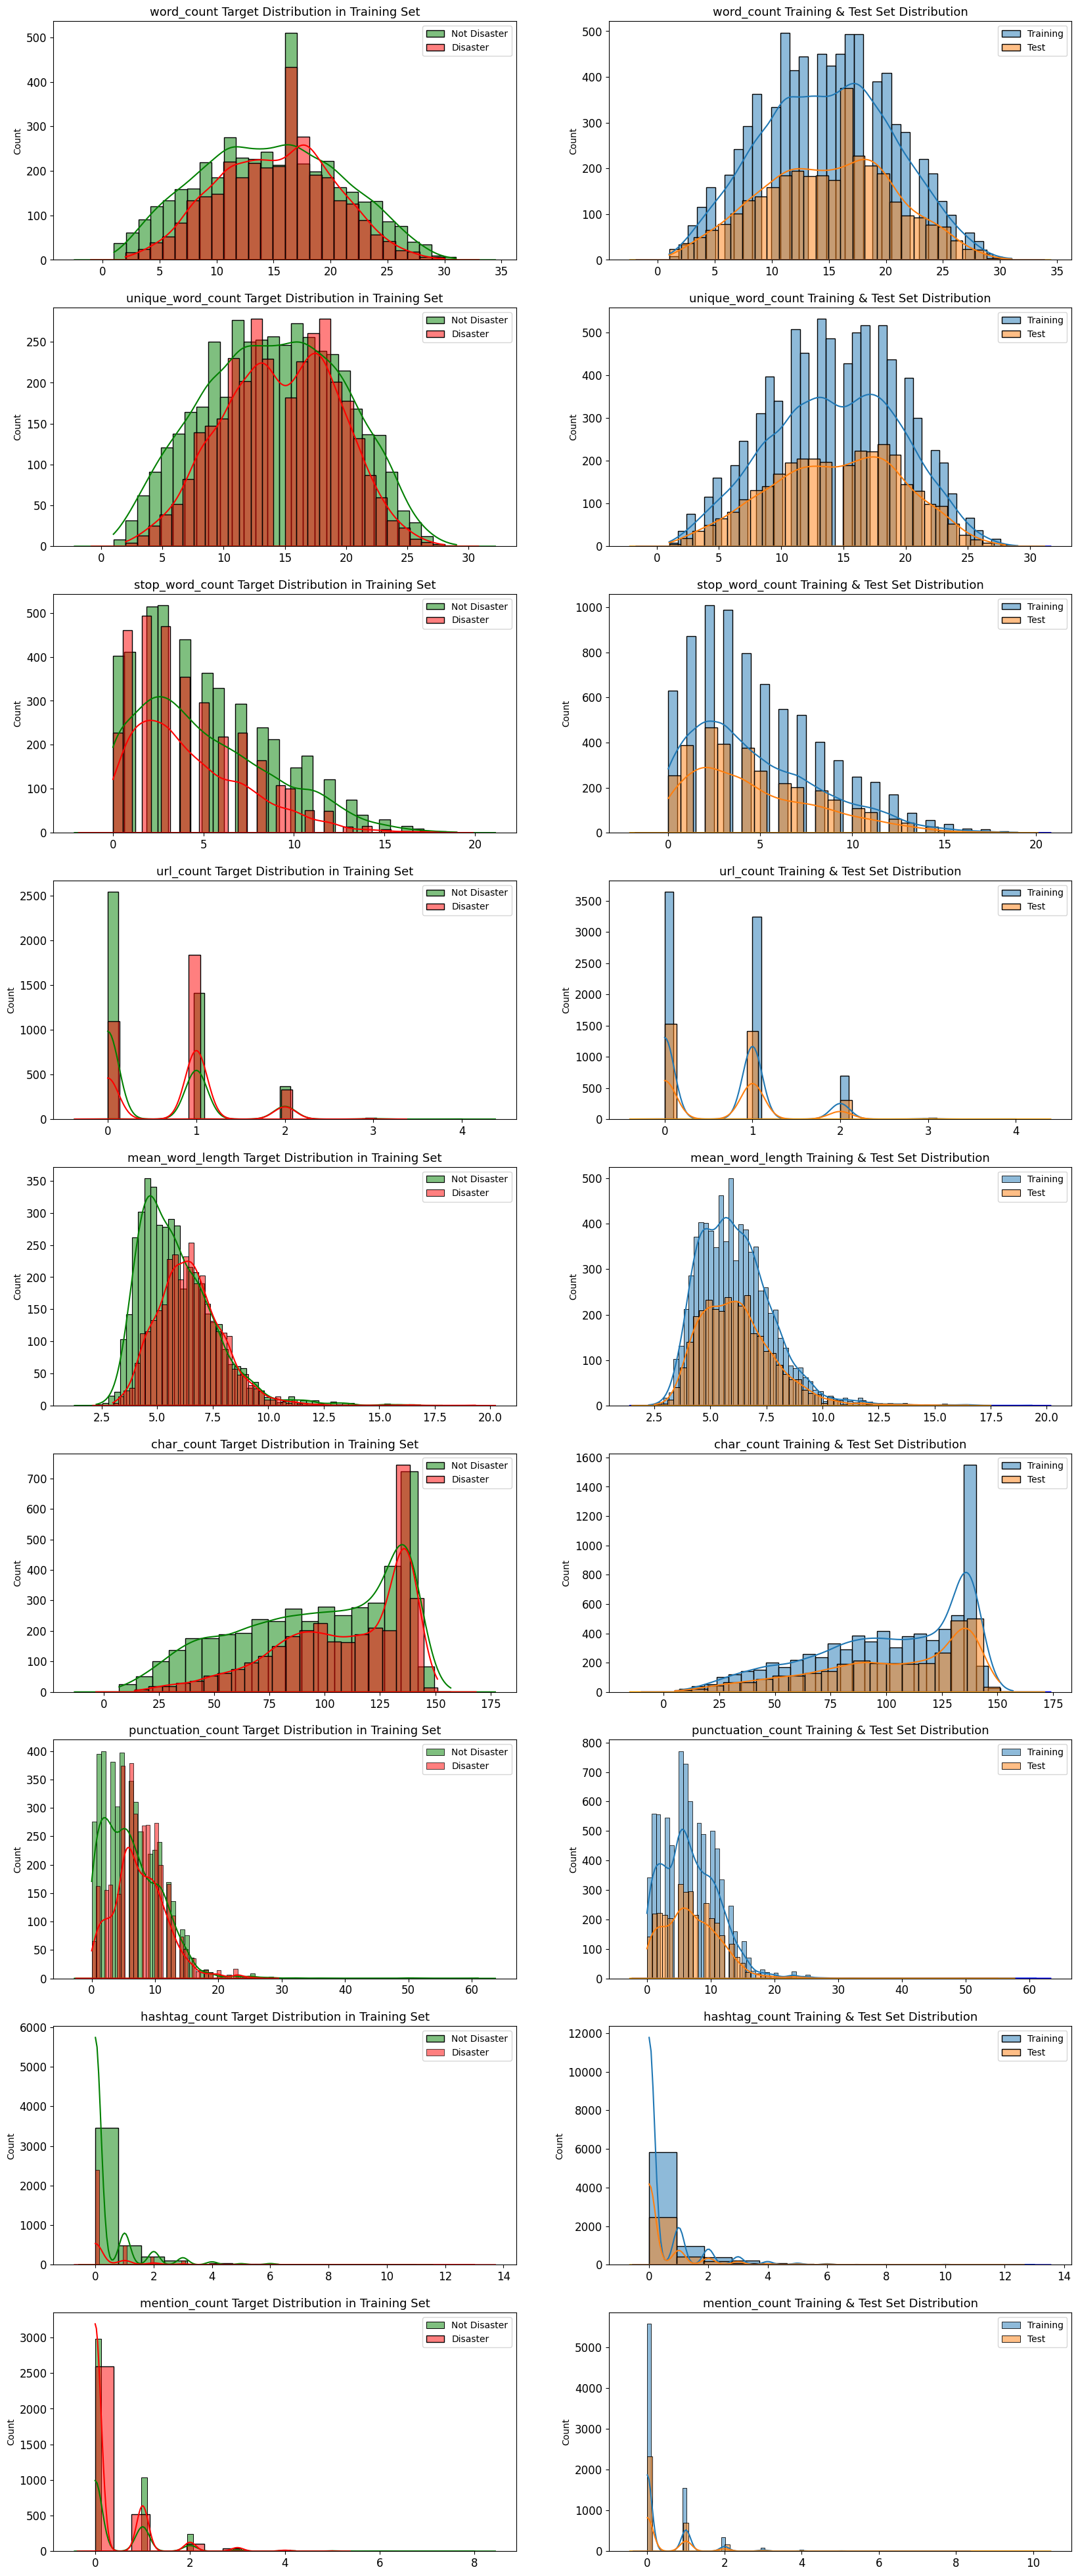

In [ ]:
warnings.filterwarnings('ignore')

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(train_df.loc[~DISASTER_TWEETS][feature], kde=True, label='Not Disaster', color='green', ax=axes[i][0])
    sns.histplot(train_df.loc[DISASTER_TWEETS][feature], kde=True, label='Disaster', color='red', ax=axes[i][0])
    sns.kdeplot(train_df.loc[~DISASTER_TWEETS][feature], color='green', ax=axes[i][0])
    sns.kdeplot(train_df.loc[DISASTER_TWEETS][feature], color='red', ax=axes[i][0])

    sns.histplot(train_df[feature], kde=True, label='Training', ax=axes[i][1])
    sns.histplot(test_df[feature], kde=True, label='Test', ax=axes[i][1])
    sns.kdeplot(train_df[feature], color='blue', ax=axes[i][1])
    sns.kdeplot(test_df[feature], color='orange', ax=axes[i][1])

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [ ]:
print(f'Training data target count: \n{train_df["target"].value_counts()}')
print(f'\nTraining data target count percentage: \n{(train_df["target"].value_counts()/len(train_df["target"]))*100}')

Training data target count: 
0    4342
1    3271
Name: target, dtype: int64

Training data target count percentage: 
0    57.034021
1    42.965979
Name: target, dtype: float64


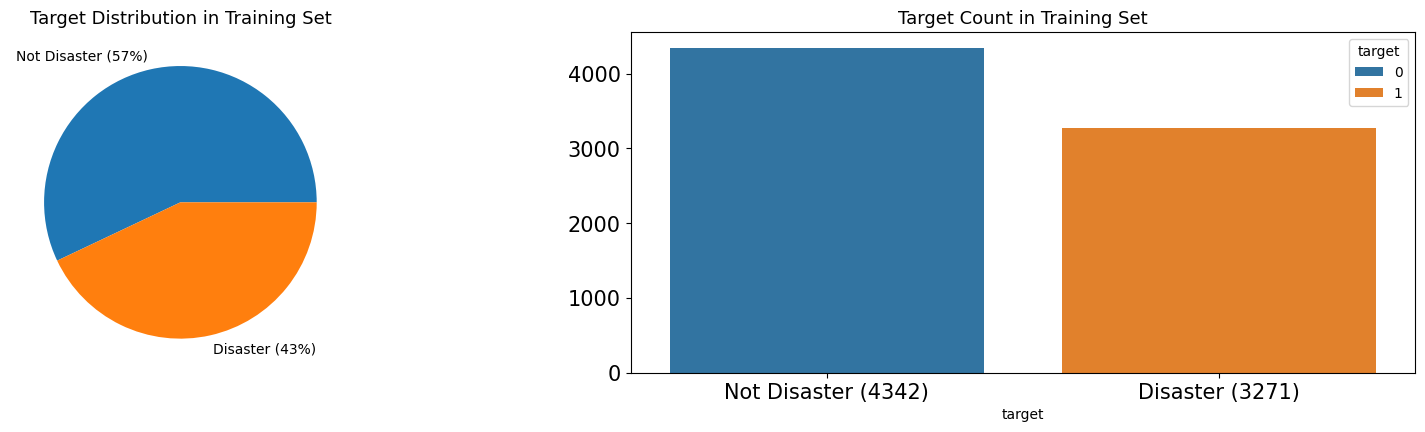

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train_df.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train_df['target'], hue=train_df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

# Text Cleaning

1. Convert all text to lowercase
2. Remove url from tweets
3. Remove special characters from tweets
4. Create tokens for each tweet
5. Do POS tagging

In [ ]:
def to_lowercase(tweet):
    loweredcase_tweet = tweet.lower()
    return loweredcase_tweet

def text_cleaning(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # remove url
    tweet = re.sub(r"[^a-zA-Z0-9\s]", "", tweet) # remove special char
    return tweet

def tokenised(tweet):
    tokens = nltk.word_tokenize(tweet)
    return tokens

def pos_tagging(tweet):
    tagged = nltk.pos_tag(tweet)
    return tagged

In [ ]:
train_df['lowered_text'] = train_df['text'].apply(lambda t : to_lowercase(t))
test_df['lowered_text'] = test_df['text'].apply(lambda t : to_lowercase(t))

train_df['clean_text'] = train_df['lowered_text'].apply(lambda t : text_cleaning(t))
test_df['clean_text'] = test_df['lowered_text'].apply(lambda t : text_cleaning(t))

train_df['tokens'] = train_df['clean_text'].apply(lambda t : tokenised(t))
test_df['tokens'] = test_df['clean_text'].apply(lambda t : tokenised(t))

train_df['pos_tags'] = train_df['tokens'].apply(lambda t : pos_tagging(t))
test_df['pos_tags'] = test_df['tokens'].apply(lambda t : pos_tagging(t))

In [ ]:
train_df['url_count_clean_text'] = train_df['clean_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count_clean_text'] = test_df['clean_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

train_df['punctuation_count_clean_text'] = train_df['clean_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count_clean_text'] = test_df['clean_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

train_df['hashtag_count_clean_text'] = train_df['clean_text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count_clean_text'] = test_df['clean_text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [ ]:
train_df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,...,punctuation_count,hashtag_count,mention_count,lowered_text,clean_text,tokens,pos_tags,url_count_clean_text,punctuation_count_clean_text,hashtag_count_clean_text
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,...,1,1,0,our deeds are the reason of this #earthquake m...,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[(our, PRP$), (deeds, NNS), (are, VBP), (the, ...",0,0,0
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,...,1,0,0,forest fire near la ronge sask. canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...",0,0,0
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,...,3,0,0,all residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[(all, DT), (residents, NNS), (asked, VBD), (t...",0,0,0
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,...,2,1,0,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...",0,0,0
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,...,2,2,0,just got sent this photo from ruby #alaska as ...,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[(just, RB), (got, VBN), (sent, VBD), (this, D...",0,0,0


In [ ]:
print("Document Count")
print(train_df.groupby('keyword')['text'].count())
print("\nWord Count")
print(train_df.groupby('keyword').apply(lambda x: x.text.apply(lambda x: len(x.split())).sum()))

Document Count
keyword
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
ambulance              38
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Name: text, Length: 222, dtype: int64

Word Count
keyword
ablaze                 501
accident               534
aftershock             507
airplane%20accident    536
ambulance              487
                      ... 
wounded                575
wounds                 540
wreck                  541
wreckage               624
wrecked                456
Length: 222, dtype: int64


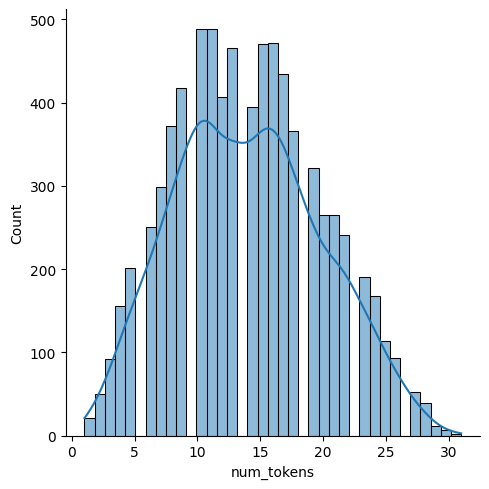

In [ ]:
train_df['num_tokens'] = [len(token) for token in train_df['tokens']]
test_df['num_tokens'] = [len(token) for token in test_df['tokens']]
sns.displot(train_df['num_tokens'], kde=True);

In [ ]:
train_df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,...,hashtag_count,mention_count,lowered_text,clean_text,tokens,pos_tags,url_count_clean_text,punctuation_count_clean_text,hashtag_count_clean_text,num_tokens
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,...,1,0,our deeds are the reason of this #earthquake m...,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[(our, PRP$), (deeds, NNS), (are, VBP), (the, ...",0,0,0,13
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,...,0,0,forest fire near la ronge sask. canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...",0,0,0,7
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,...,0,0,all residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[(all, DT), (residents, NNS), (asked, VBD), (t...",0,0,0,22
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,...,1,0,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...",0,0,0,8
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,...,2,0,just got sent this photo from ruby #alaska as ...,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[(just, RB), (got, VBN), (sent, VBD), (this, D...",0,0,0,16


# Lemmatization

In [ ]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [ ]:
tweet = list(train_df['clean_text'].values)
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2, stop_words='english', decode_error='ignore')
tf_lemm = tf_vectorizer.fit_transform(tweet)

In [ ]:
feature_names = tf_vectorizer.get_feature_names_out()
count_vec = np.asarray(tf_lemm.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))

top_words = x[:50]
top_frequencies = y[:50]

bottom_words = x[-50:]
bottom_frequencies = y[-50:]

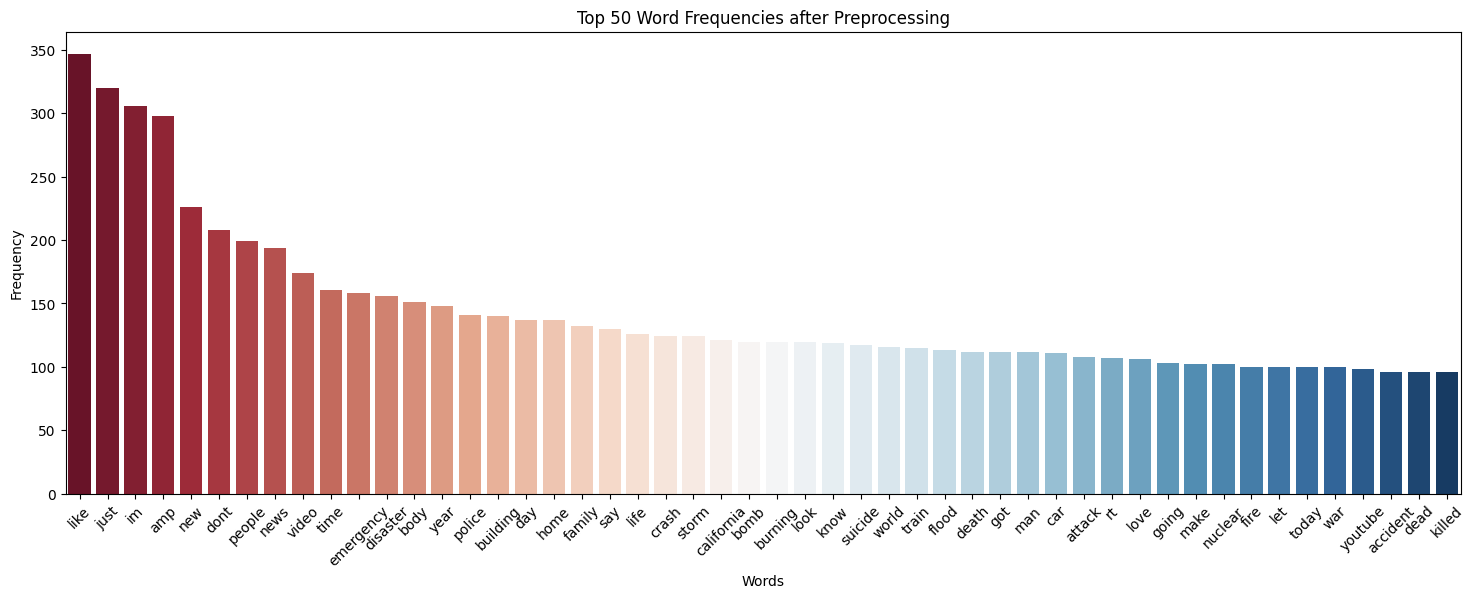

In [ ]:
plt.figure(figsize=(18, 6))

sns.barplot(x=top_words, y=top_frequencies, palette='RdBu')
plt.title('Top 50 Word Frequencies after Preprocessing')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

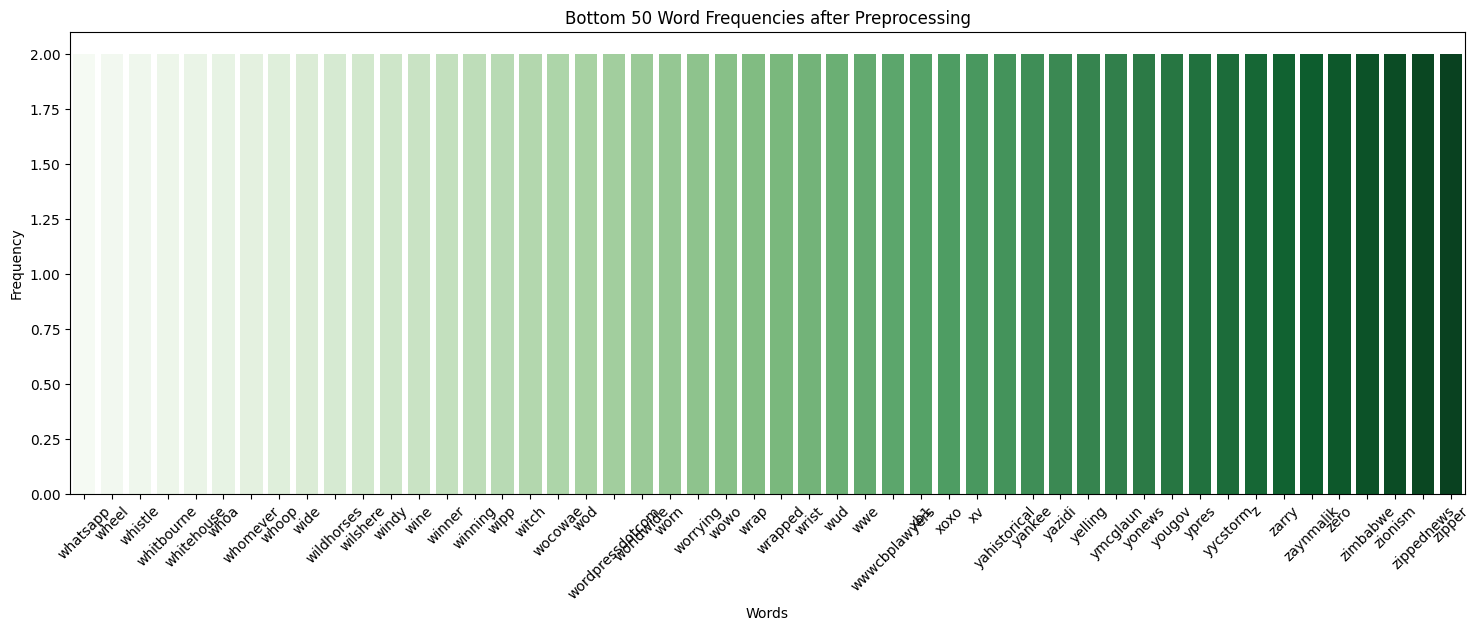

In [ ]:
plt.figure(figsize=(18, 6), dpi=100)

sns.barplot(x=bottom_words, y=bottom_frequencies, palette='Greens')
plt.title('Bottom 50 Word Frequencies after Preprocessing')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Latent Dirichlet Allocation (LDA)

In [ ]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5, learning_method='online', learning_offset=50., random_state=0)
lda.fit(tf_lemm)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [ ]:
n_top_words = 30
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:people weapon let flood say suicide youre collapse saudi right 2015 official mosque terrorist face natural content nuclear bomber isi 15 august meltdown light book bridge screamed hollywood hazard reactor

Topic #1:emergency body siren old building woman bag city reddit run burning story loud screaming spill ruin shot riot tonight rescue rioting breaking there food quarantine service baby evacuation new news

Topic #2:world dead suicide thing wreck nuclear water attack migrant disaster survivor rescued thunder hundred case possible seismic away boat horror twitter government rescuer projected hell texas maybe think windstorm human

Topic #3:bomb war watch killed hiroshima help army bombing military hope lightning japan road terrorism violent atomic sandstorm county news summer zone save damage fan airport horrible go child cause swallowed

Topic #4:got need mh370 god malaysia wreckage confirmed stock im sinkhole traumatised china fucking trouble fall mi

# Generating N-grams

In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['clean_text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1

for tweet in train_df[~DISASTER_TWEETS]['clean_text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['clean_text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1

for tweet in train_df[~DISASTER_TWEETS]['clean_text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1

df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['clean_text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1

for tweet in train_df[~DISASTER_TWEETS]['clean_text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1

df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

## Unigrams

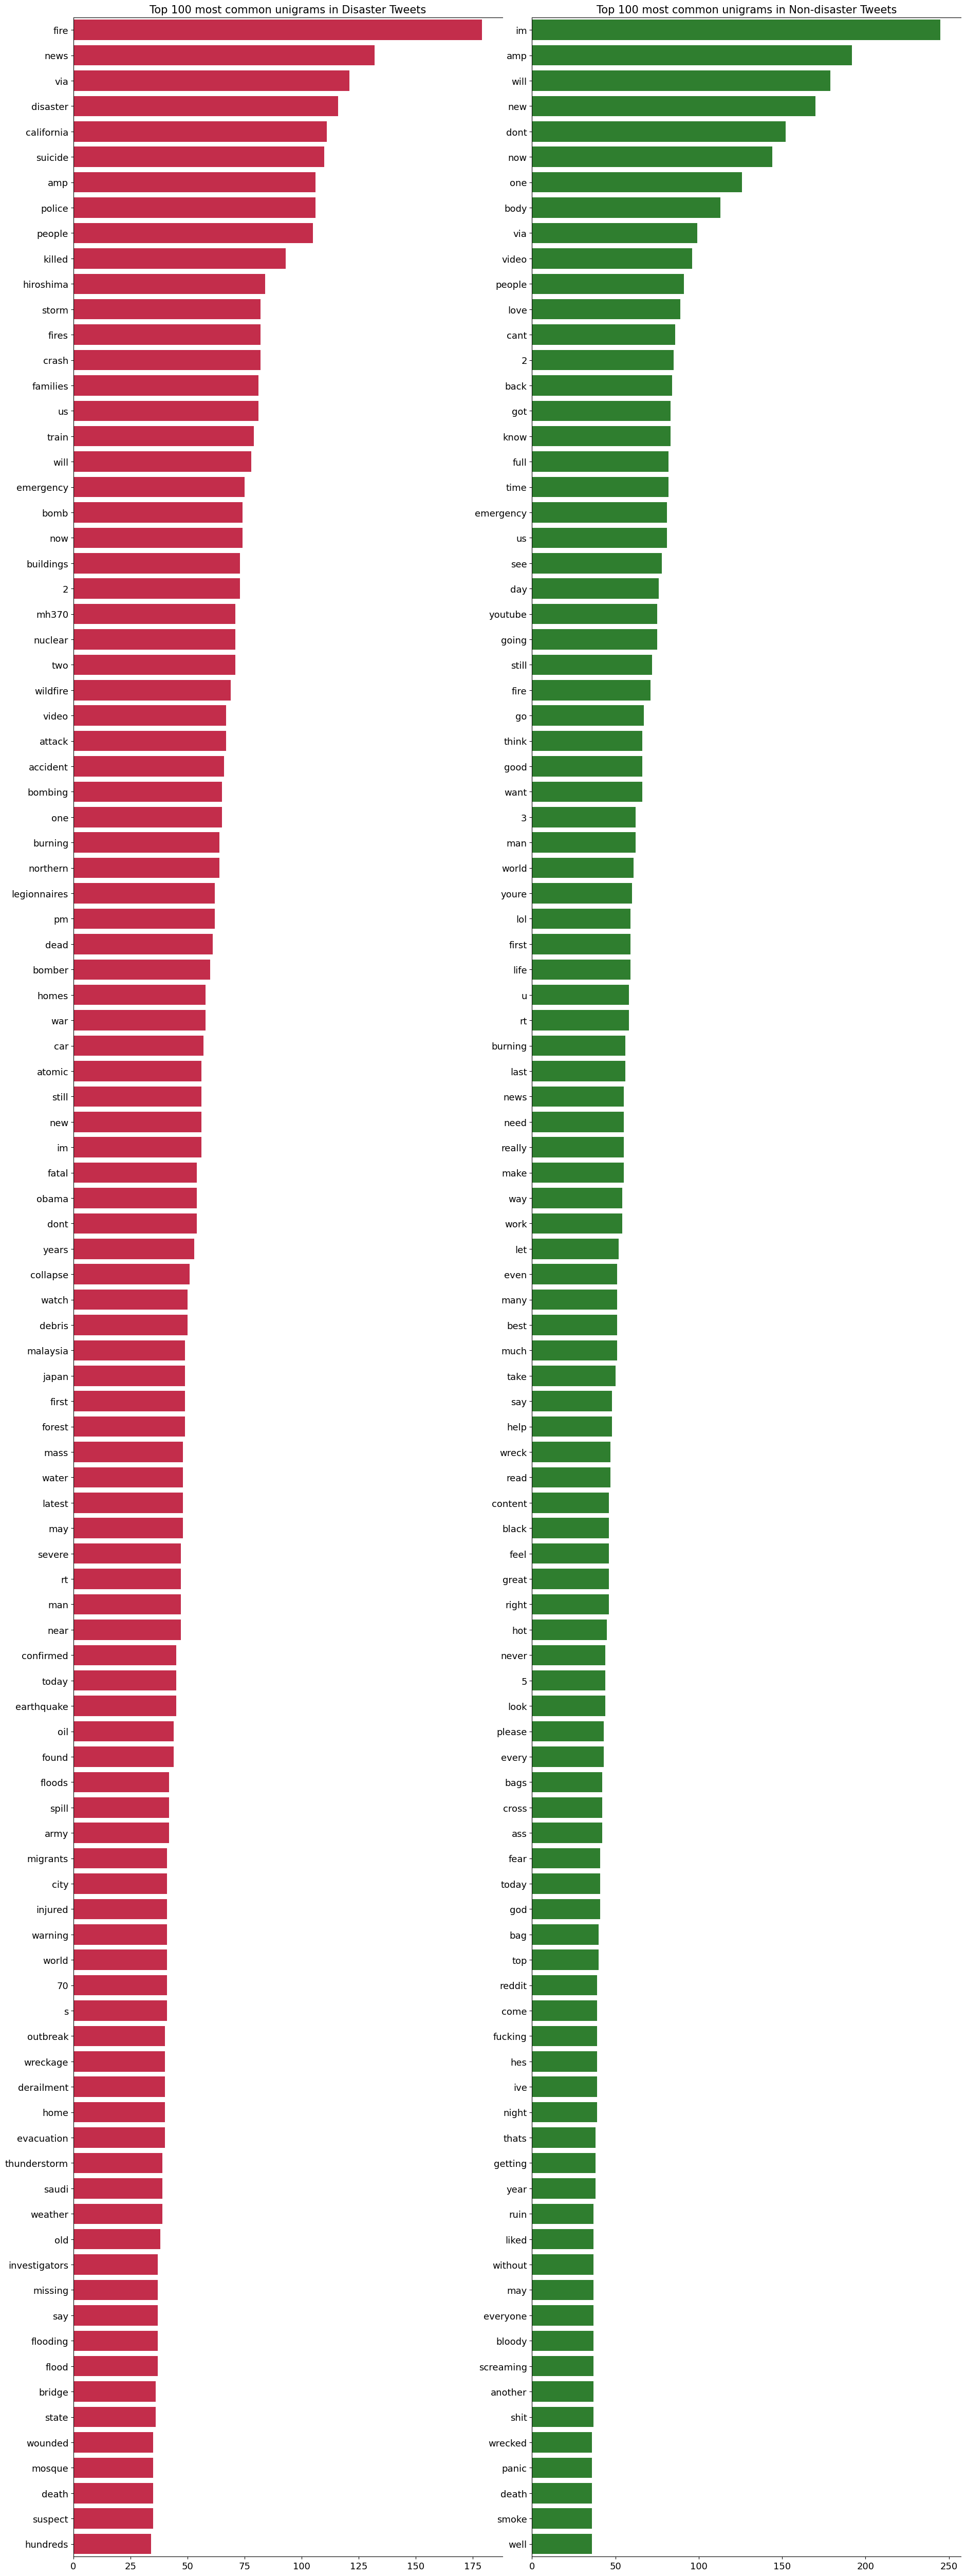

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='crimson')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='forestgreen')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

## Bigrams

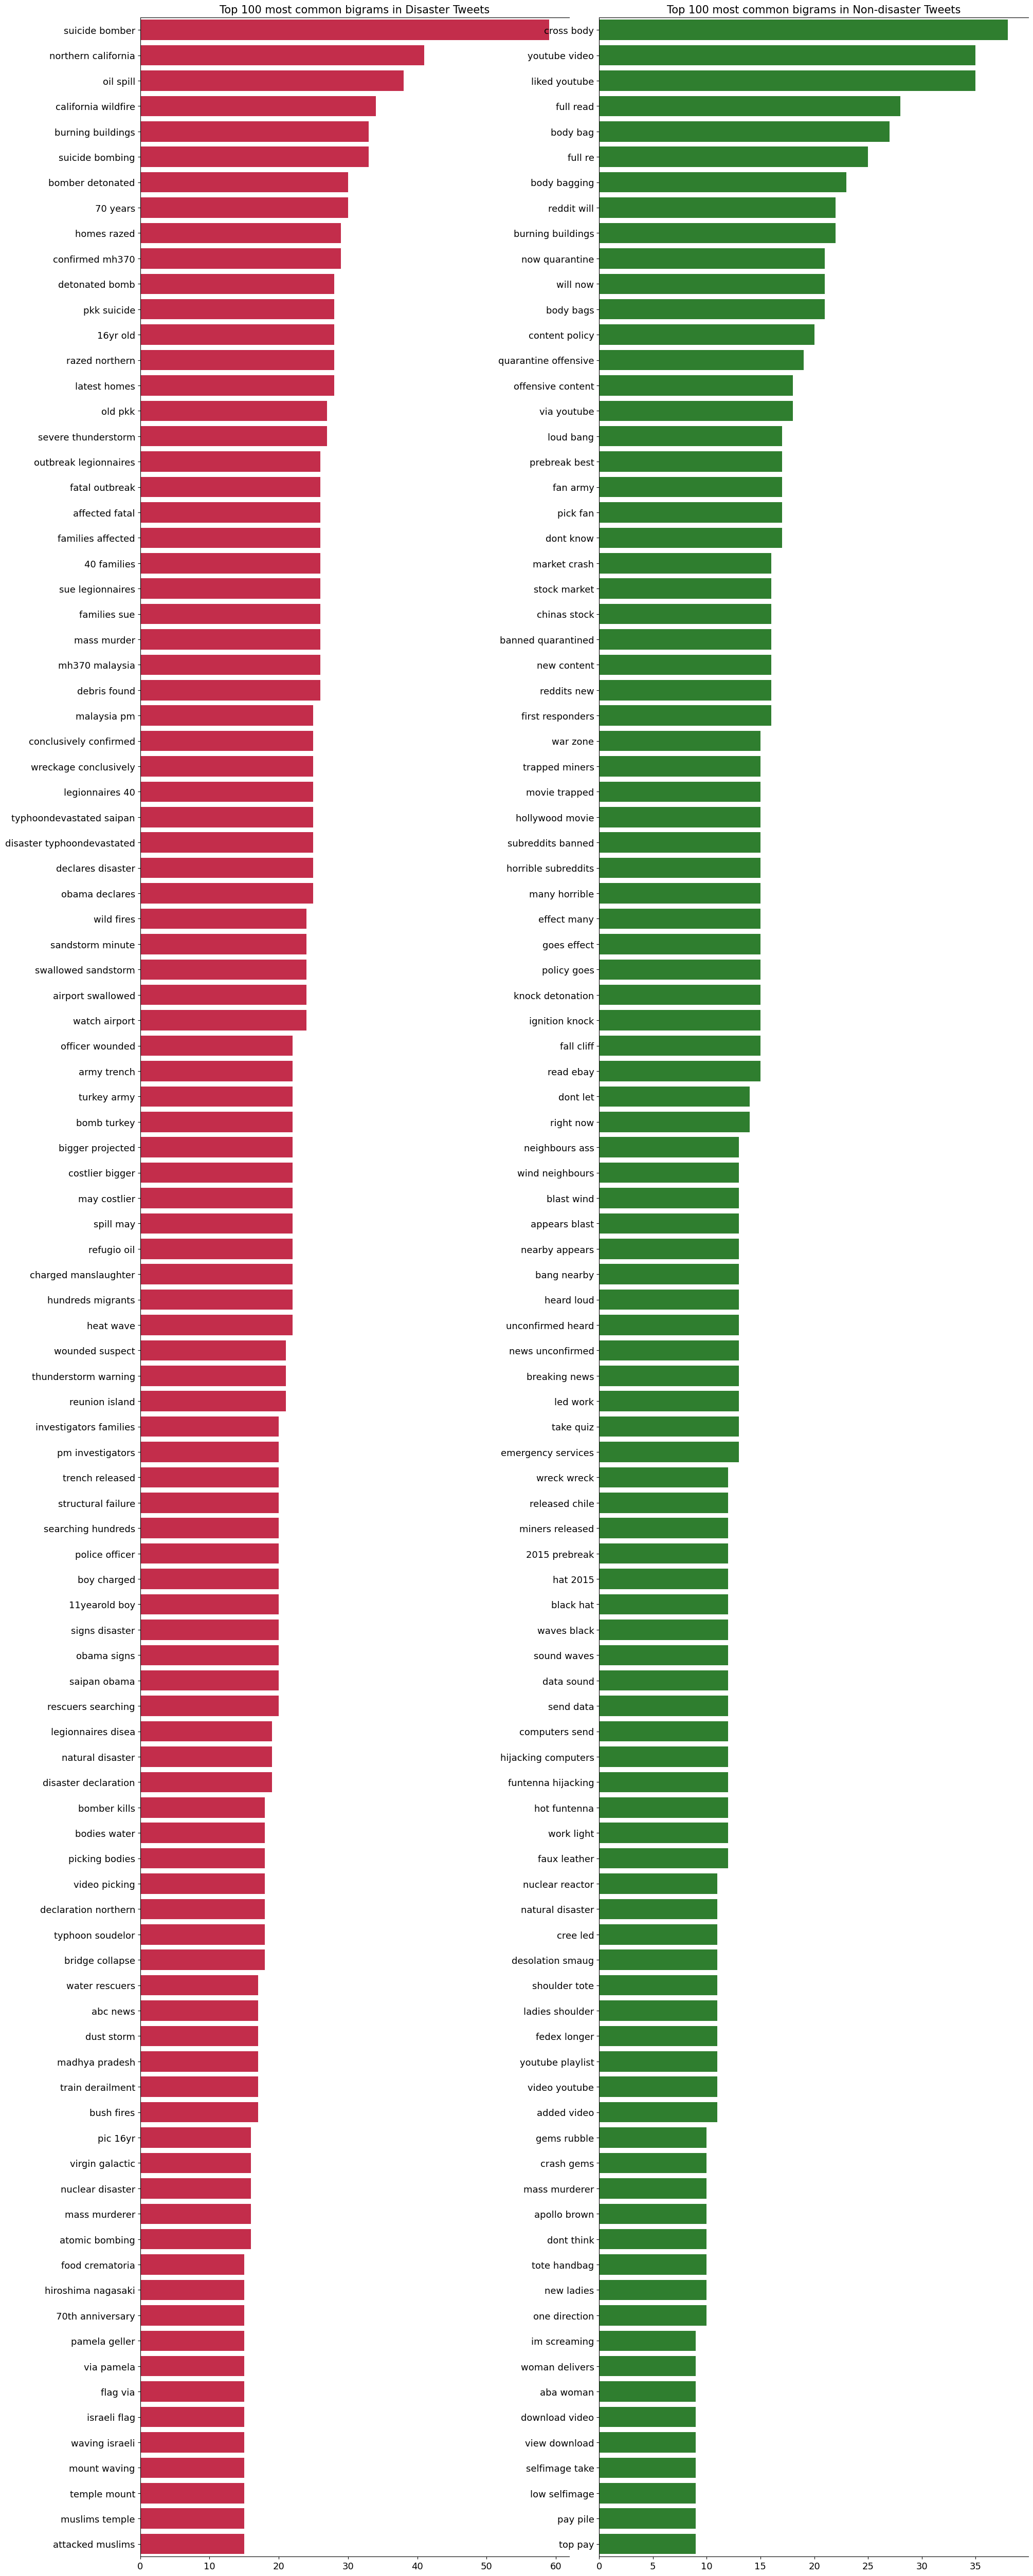

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='crimson')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='forestgreen')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

## Trigrams

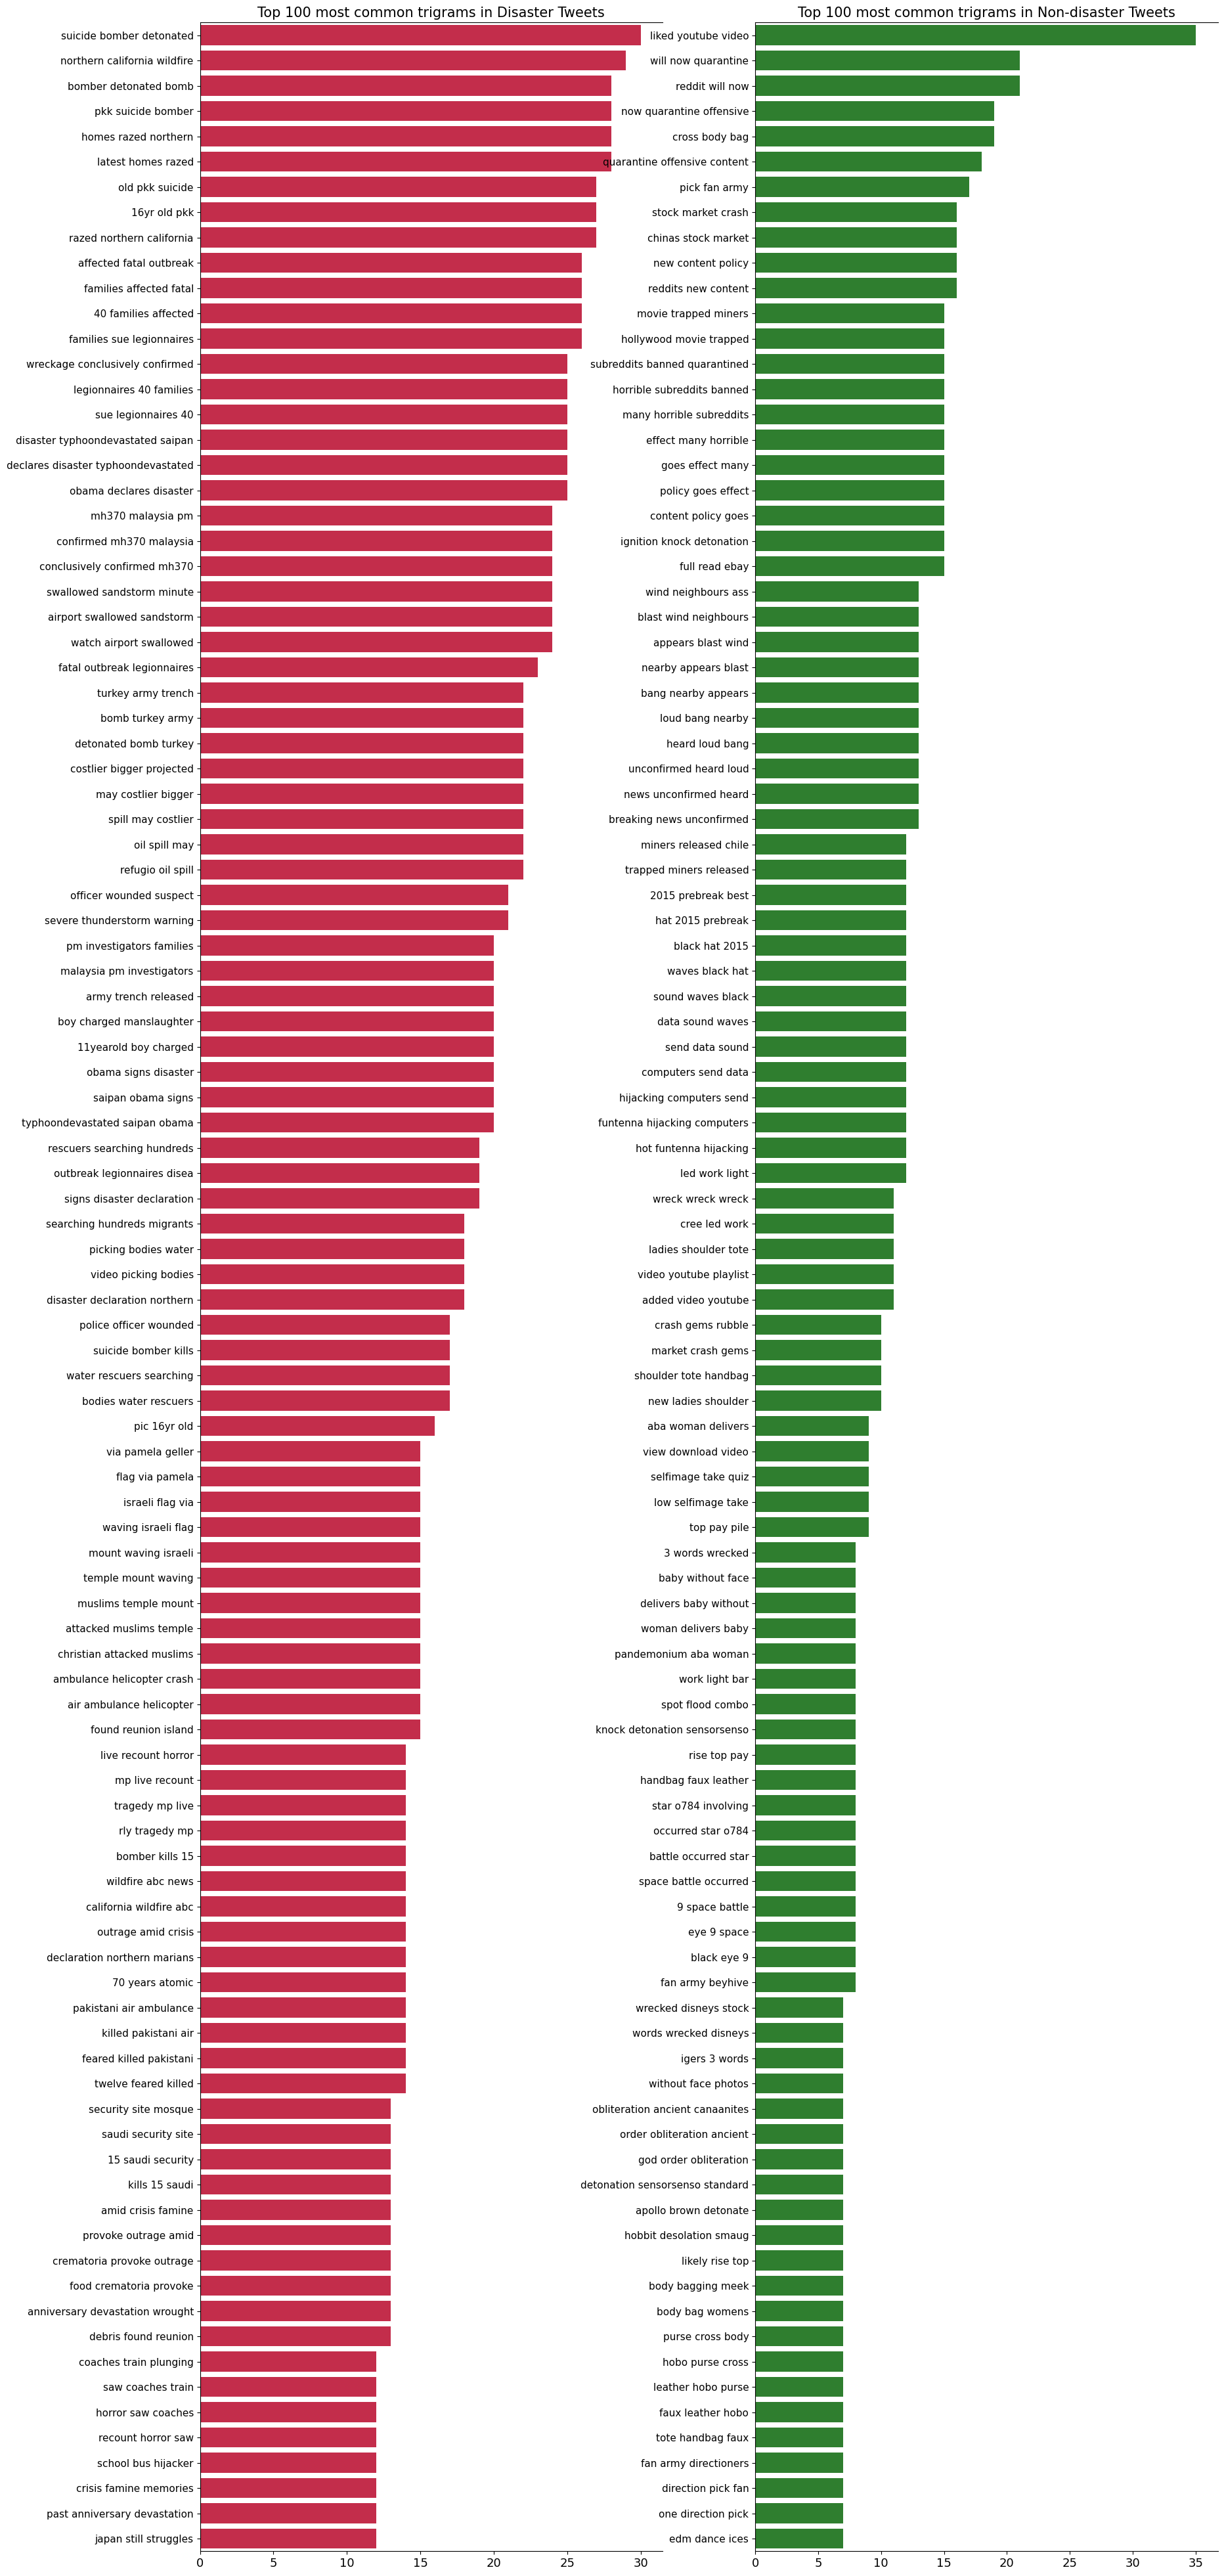

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='crimson')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='forestgreen')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [ ]:
train_df.to_csv('train_preprocessed.csv')
test_df.to_csv('test_preprocessed.csv')

Reference used

https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert